In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import json
from ops.utils import*
from matplotlib.colors import ListedColormap
import os
import shutil 
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2_video_predictor
from tqdm import tqdm

In [25]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)
    

def calculate_centroid_and_distance(masks, image_shape=(512, 640)):
    center_x, center_y = image_shape[1] // 2, image_shape[0] // 2  # center of the image
    
    results = []
    min_distance = float('inf')
    closest_index = -1
    
    for index, mask in enumerate(masks):
        segmentation = mask['segmentation']
        
        # Get indices of True values
        indices = np.where(segmentation)
        if indices[0].size == 0 or indices[1].size == 0:
            # No true values in the mask
            centroid = (None, None)
            distance = None
        else:
            # Compute centroid
            centroid_x = np.mean(indices[1])
            centroid_y = np.mean(indices[0])
            centroid = (centroid_x, centroid_y)
            
            # Compute distance from the image center
            distance = np.sqrt((centroid_x - center_x) ** 2 + (centroid_y - center_y) ** 2)
        
            # Check if this mask is the closest one
            if distance is not None and distance < min_distance:
                min_distance = distance
                closest_index = index
        
        # Store results
        results.append({
            'centroid': centroid,
            'distance_from_center': distance
        })
        
    return results, closest_index

In [26]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [27]:

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

In [28]:
_Num_Required_Frames= 300
_Num_Masks = 20

masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4_v3/CREDgt_set_4/Masks/"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/20240708_09_00_12072024_113101.raw"
_unique_id='gt4_v3_ew8r3'



masks_directory = None
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240610/20240604_11_00/20240604_11_00_10062024_152218.raw"
_unique_id='CIRP_ew8r3_d1'
N_Frames=13265
Start=18185 
End=122585


masks_directory = None
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240606/20240604_4_00/20240604_4_00_06062024_140548.raw"
_unique_id='CIRP_ew8r3_d2'
N_Frames=126878
Start=17599
End=120360


masks_directory = None
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240610/20240604_14_00/20240604_14_00_10062024_165551.raw"
_unique_id='CIRP_ew8r3_d3'
N_Frames=247835
Start=33951
End=24359

skip_rate = (End - Start)//_Num_Required_Frames
masks_skip_rate = _Num_Required_Frames//_Num_Masks

# Temporary directory to save reordered frames
temp_dir = raw_video_dir.replace("/Data/RAW/ByDay/", "/Data/Processed/Noisy_Pseudo_Masks/").replace(".raw", f"/{_unique_id}/")
# temp_dir = f"./videos/{data_set_tag}/"
orginal_dir = f"{temp_dir}/orginal/"
sam_temp_dir = f"{temp_dir}/sam/temp/"
sam_results_dir = f"{temp_dir}/sam/results/"
xinyue_dir = f"{temp_dir}/xinyue/"
raw_dir = f"{temp_dir}/raw/"
masks_gt_dir = f"{temp_dir}/masks_gt/"



In [29]:
masks_skip_rate

15

In [30]:
data_set_tag = f'noisy_unique_id{_unique_id}'
if masks_directory is not None:
    flood_masks = sort_and_filter_images(masks_directory, "_c1")   # Sort and filter the images
    voids_masks = sort_and_filter_images(masks_directory, "_c2")   # Sort and filter the images
    masks_frames = [int(name.split('_f_')[1].split('_')[0]) for name in flood_masks]

In [31]:
if masks_directory is not None:
    slected_mask_index = 5 # the index is the order of the mask in the list of masks xinyue has labeled.
    mask_frame = masks_frames[slected_mask_index] # index based camera frame number
    flood_mask_path = flood_masks[slected_mask_index]
    voids_mask_path = voids_masks[slected_mask_index]
else:
    slected_mask_index = None


In [32]:
parameters = {
    "mask_frame_used": slected_mask_index,
    "model_name": "SAM 2",
    "raw_file_directory": raw_video_dir,
    "masks_directory": masks_directory,
    "_Num_Required_Frames": _Num_Required_Frames,
    "skip_rate": skip_rate,
    "unique_id": _unique_id,
    "temp_dir": temp_dir,
    "orginal_dir": orginal_dir,
    "sam_temp_dir": sam_temp_dir,
    "sam_results_dir": sam_results_dir,
    "xinyue_dir": xinyue_dir,
    'sam2_checkpoint': sam2_checkpoint,
    'model_cfg': model_cfg,
    '_unique_id':_unique_id,
    'N_Frames':N_Frames,
    'Start':Start,
    'End':End,
    'skip_rate':skip_rate,
    'masks_skip_rate':masks_skip_rate,
    'raw_dir':raw_dir,
    '_Num_Masks':_Num_Masks,
}

In [33]:
# shutil.rmtree(temp_dir, ignore_errors=True)  # Remove the directory if it already exists
shutil.rmtree(sam_temp_dir, ignore_errors=True)
os.makedirs(temp_dir, exist_ok=True) 
os.makedirs(xinyue_dir, exist_ok=True) 
# os.makedirs(orginal_dir, exist_ok=True) 
os.makedirs(sam_temp_dir, exist_ok=True)
os.makedirs(sam_results_dir, exist_ok=True)
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(masks_gt_dir, exist_ok=True)

# os.makedirs(f"{sam_results_dir}/masks/", exist_ok=True) 
# os.makedirs(f"{sam_results_dir}/overlay/", exist_ok=True) 
dict_of_lists={}
dict_of_lists['frames_indices'] = []
dict_of_lists['is_gt'] = []
dict_of_lists['raw_image_path'] = []
dict_of_lists['mask_image_path'] = []
counter=1
image_meta_data = {'filename_abs': raw_video_dir, 'height': 512, 'width': 640}
for i in tqdm(np.arange(Start,End,skip_rate)): # index based camera frame number
    is_gt = 0
    frame = open_frame_firstlight(image_meta_data, i)
    img_array = frame['img']
    
    dict_of_lists['mask_image_path'].append(f"NA")
    img = Image.fromarray(img_array)
    img = img.convert('L')
    # img.save(f"{orginal_dir}/{i}.jpg") 
    img.save(f"{sam_temp_dir}/{counter}.jpg") # sam index 1,2,3,4,5,6,7,8,9,10,..........
    img.save(f"{raw_dir}/{counter}.jpg") # sam index 1,2,3,4,5,6,7,8,9,10,..........
    dict_of_lists['frames_indices'].append(i)
    if (counter == 1) or (counter% masks_skip_rate == 0):
        img.save(f"{masks_gt_dir}/{counter}.jpg") # sam index 1,2,3,4,5,6,7,8,9,10,..........
        is_gt = 1
        dict_of_lists['mask_image_path'].append(f"{masks_gt_dir}/{counter}.jpg")
    dict_of_lists['is_gt'].append(is_gt)
    dict_of_lists['raw_image_path'].append(f"{raw_dir}/{counter}.jpg")
    
    mask_generator = SAM2AutomaticMaskGenerator(predictor)
    image = np.array(img.convert("RGB"))
    masks = mask_generator.generate(image)
    if len(masks) == 0:
        mask_img = Image.fromarray(np.zeros((512, 640), dtype=np.uint8))
    else:
        #centriods,closest_to_center=calculate_centroid_and_distance(masks)
        for mask_counter, mask in enumerate(masks):
            mask_img = Image.fromarray(mask['segmentation'])
            mask_img = mask_img.convert('L')
            mask_img.save(f"{sam_results_dir}/{counter}_{mask_counter}.jpg")
    counter+=1

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [09:43<00:00,  1.94s/it]


In [34]:
data_frame = pd.DataFrame([dict_of_lists['frames_indices'], dict_of_lists['is_gt'],dict_of_lists['raw_image_path'],dict_of_lists['mask_image_path']]).T
data_frame.columns = ['Manfacturer_counter', 'is_gt', 'raw_image_path', 'mask_image_path']
data_frame['train'] = 0
data_frame['test'] = 0
data_frame['val'] = 0
data_frame['noisy_train'] = 0



In [35]:
labeld_index = data_frame[data_frame['is_gt']==1].index


In [36]:
train_labeld_index = labeld_index[:int(len(labeld_index)*0.5)]
val_labeld_index = labeld_index[int(len(labeld_index)*0.5):int(len(labeld_index)*0.75)]
test_labeld_index = labeld_index[int(len(labeld_index)*0.75):]
train_nosy_index_interval = min(train_labeld_index), max(train_labeld_index)



In [37]:
print(train_labeld_index, val_labeld_index, test_labeld_index)

Index([0, 14, 29, 44, 59, 74, 89, 104, 119, 134], dtype='int64') Index([149, 164, 179, 194, 209], dtype='int64') Index([224, 239, 254, 269, 284, 299], dtype='int64')


In [38]:
data_frame.loc[train_labeld_index,'train'] = 1 
data_frame.loc[val_labeld_index,'val'] = 1 
data_frame.loc[test_labeld_index,'test'] = 1
data_frame.loc[train_nosy_index_interval[0]:train_nosy_index_interval[1],'noisy_train'] = 1


In [39]:
data_frame.to_csv(f"{temp_dir}/data.csv", index=True, header=True)

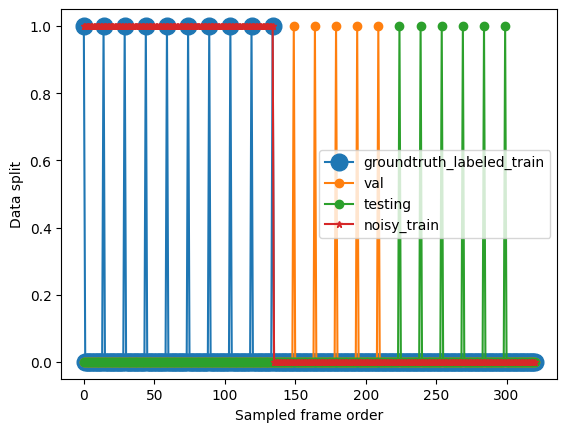

In [40]:
fig, ax = plt.subplots()
ax.plot(data_frame.index,data_frame['train'], label='groundtruth_labeled_train',marker = 'o', linestyle = '-',markersize=12)
ax.plot(data_frame.index,data_frame['val'], label='val',marker = 'o', linestyle = '-')
ax.plot(data_frame.index,data_frame['test'], label='testing',marker = 'o', linestyle = '-')
ax.plot(data_frame.index,data_frame['noisy_train'], label='noisy_train',marker = '*', linestyle = '-',markersize=5)
ax.set_xlabel('Sampled frame order')
ax.set_ylabel('Data split')
ax.legend()

In [41]:
# save the dictionary
with open(f"{temp_dir}/parameters.json", 'w') as json_file:
    json.dump(parameters, json_file)

In [42]:
temp_dir

'/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/20240610/20240604_14_00/20240604_14_00_10062024_165551/CIRP_ew8r3_d3/'